## Simulated data and ABC-MCMC

We simulate parallax and parallax error for the DBSCAN-selected stars within a cluster in order to test the aprroximate Bayesian computation (ABC) <br>

For the simulated data the **input parameters** are: <br>
 * D_c     : Cluster distance 
 * N_s     : Star numbers
 * sigma_x : X physical standard deviation of the cluster
 * err_p : distribution to simulate the parallax error on each star
 
 
The **output products** will be:
 * Array of N points with:
     * simulated parallax
     * simulated parallax error

In [40]:
#### package and types
####
using Random , Compat ,  Distributions
import PyPlot; const plt = PyPlot

## type starCluster
mutable struct starCluster
    xpos::Array{Float64}    ## x position
    sigma_x::Float64        ## std position
    ns::Int32               ## star number
    dc::Float64             ## cluster distance
end

## GAIA observations
mutable struct simGaia
    parallax::Array{Float64}
    parallax_err::Array{Float64}
end

In [41]:
### data simulation

function create_cluster(ns = 1000 , dc = 380. , sigma_x = 2.7)::starCluster
    d = Normal(0.0, sigma_x)
    cluster = starCluster(zeros(ns) , sigma_x , ns, dc)
    cluster.xpos = rand(d, ns)
    
    return(cluster)
end

function create_gaia(c::starCluster, stderr, minerr)::simGaia
    gaia = simGaia(zeros(c.ns) , zeros(c.ns))
    
    err = Truncated(Normal(0.0, stderr), minerr , 1e9)
    gaia.parallax_err = rand(err, c.ns)
    
    ## actual error draw from the error distribution
    actualErr = zeros(c.ns)
    for i in 1:c.ns
        errd = Normal(0.0, gaia.parallax_err[i])
        actualErr[i] = rand(errd)
    end
    
    gaia.parallax = 1000. ./ ( c.dc .+ c.xpos) .+ actualErr
    
    return(gaia)
end

create_gaia (generic function with 1 method)

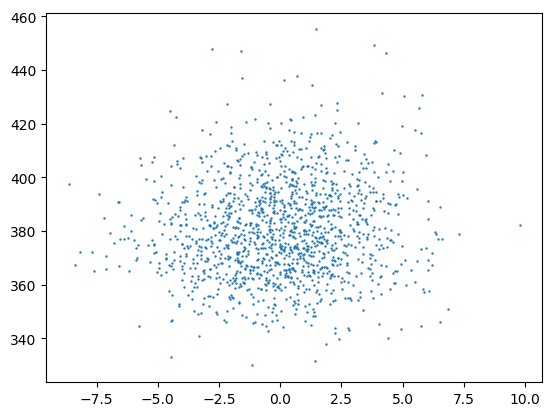

18.044847757886522

In [42]:
## Main program
## 

## Create the simulated data ...

Random.seed!(123)

c1   = create_cluster(1400, 380., 2.7)
c2   = create_cluster(1400, 380., 2.7)
gaia = create_gaia(c1, 0.011 , 0.12)

d = 1000. ./ gaia.parallax
plt.scatter(c2.xpos , d, s = 0.5 )
plt.show()

std(d)